This notebook will be used with the aim of showing how a linear regression works:

# 1. Set up

# 2. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, roc_auc_score, roc_curve, confusion_matrix


import category_encoders as ce

In [2]:
import warnings

warnings.simplefilter("ignore")

# 3. Define global variables

In [3]:
INPUT_PATH = "../../data/credit_card_data/data_modified_binary_classification.csv"

# 4. Functions

# 5. Code

We are going to create a simple binary classification model, making use of the data we transformed in the *00_transform_data_binary_classification.ipynb* notebook. All needed information about the data is sotred there.

## 5.1. Load and transform data

First of all we are going to load the both the data and the target variables making use of pandas library

In [4]:
data = pd.read_csv(INPUT_PATH, sep=";")
data.head()

,car_owner,propert_owner,children,type_income,education,marital_status,housing_type,employed_days,mobile_phone,work_phone,phone,email_id,family_members,target
0,Y,Y,0,Pensioner,Higher education,Married,House / apartment,365243,1,0,0,0,2,1
1,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
2,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
3,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
4,Y,N,0,Pensioner,Higher education,Married,House / apartment,-586,1,1,1,0,2,1


### Train / test split

Before doing transformations in the data, we need to divide it into train and test. **Let's remember that all transformations must be fitted in the training dataset**

In [5]:
X = data.drop("target", axis=1)
y = data["target"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We need to transform all categorical columns to numeric. We'll do it fast making use of the target encoder:

In [7]:
categorical_cols = data.select_dtypes(include="object").columns

We are going to use target encoder in order to transform the categorical data:

In [8]:
target_encoder = ce.TargetEncoder(cols = categorical_cols)

In [9]:
X_train_processed = target_encoder.fit_transform(X_train, y_train)
X_test_processed = target_encoder.transform(X_test)

## 5.2. Training

A simple random forest will be used in order to train the data. Let's remember this is a notebook where classification matrics are the main character and no the model!

In [10]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier on the training data
rf_classifier.fit(X_train_processed, y_train)

RandomForestClassifier(random_state=42)

We are going to calculate the predictions of the model. Since by default when we calculate predictions, the threshold is set to 0.5, we will change it to 0.2 in order to get better metrics result, althought the threshold is something we have to be careful about!

In [11]:
# consider probabilistic predictions of the positive class!
probabilistic_predictions = rf_classifier.predict_proba(X_test_processed)[:, 1]

predictions = np.where(probabilistic_predictions >= 0.2, 1, 0)

## 5.3. Metrics calculation

Let's start with the aim of this notebook, getting to know our classification metrics:

### 5.3.1. Confusion matrix

In [12]:
conf_matrix = confusion_matrix(y_test, predictions)

Let's plot this confusion matrix:

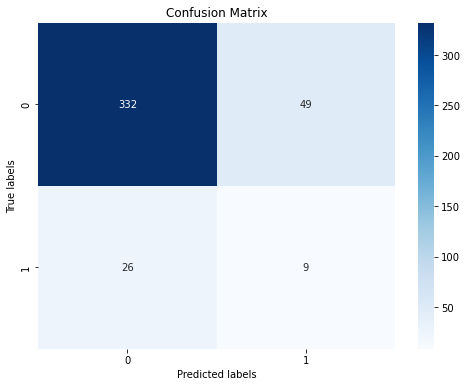

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### 5.3.1. Accuracy

In [14]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8197115384615384


This means that the model correctly predicts around 82% of the instances in the dataset. But, if we observe the confusion matrix we can observe that this is not great news because we are getting a lot of incorrect predictions for our positive class!

### 5.3.2. Precision and recall

In [15]:
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.15517241379310345
Recall: 0.2571428571428571


This time, we can observe the following:

- On the one hand, only around 15.5% of the instances predicted as positive by the model are actually true positives.
- We have a low precision, so many instances predicted as positive are actually negative.
- On the other hand, a recall of 25.7% indicates that the model correctly identifies approximately 25.7% of all actual positive instances in the dataset.
- This means that the model misses a significant portion of actual positive cases.

### 5.3.4. F1 score

In [16]:
f1 = f1_score(y_test, predictions)
print(f"F1 score: {f1}")

F1 score: 0.19354838709677422


This is a result of what we have seen before with the precision and recall. Let's remember that f1 score represents an harmonic mean of precision and recall, so bad result in both will lead to a bad result in f1 score. 

### 5.3.5. AUC and roc curve

In [17]:
auc = roc_auc_score(y_test, probabilistic_predictions)
print(f"AUC score: {auc}")

AUC score: 0.5935883014623173


Let's start with the plot of the roc curve, first, we need the fpr, tpr and thresholds values:

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, probabilistic_predictions)

Now, we have all the info in order to plot it:

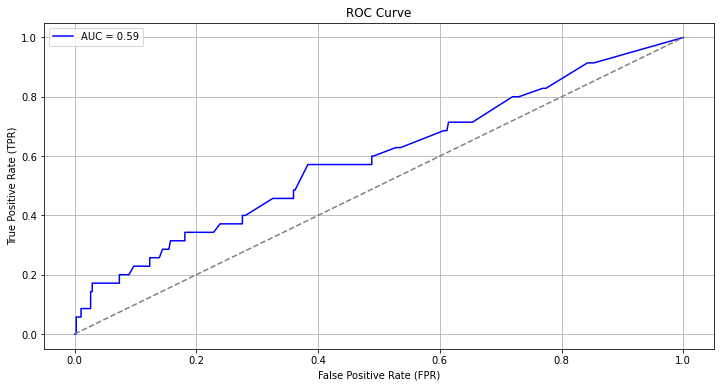

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {round(auc, 2)}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

The AUC value of 0.59 indicates that the model has some ability to distinguish between positive and negative instances, but its discriminatory power is modest. Let's remember that the higher the AUC score, the better the model's ability to differentiate between positive and negative instances.

If we attend to the roc curve, we can see that it is no far away from the random diagonal line... as the auc score tells us

### 5.3.6. Gain and lift curves

We'll start first with the gain curve. Since we need to make some calculations with y_test, we'll take only its values:

In [20]:
y_test_array = y_test.values

Now we need to arange the results from the most probabilistic result to the less:

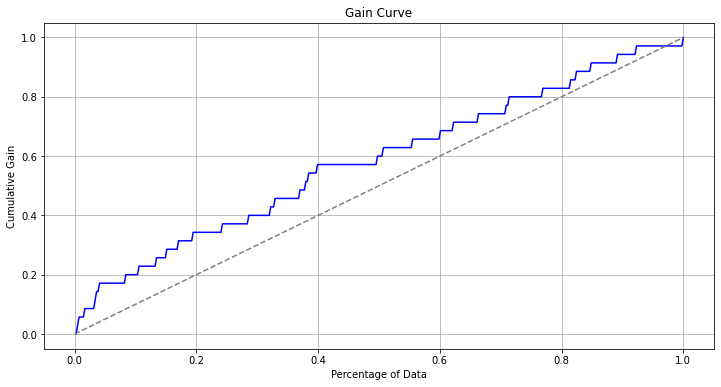

In [21]:
sorted_indices = np.argsort(probabilistic_predictions)[::-1]
cumulative_gain = np.cumsum(y_test_array[sorted_indices]) / np.sum(y_test_array)
cumulative_percent = np.arange(1, len(y_test_array) + 1) / len(y_test_array)

# Plot Gain curve
plt.figure(figsize=(12, 6))
plt.plot(cumulative_percent, cumulative_gain, color="blue")
plt.plot([0, 1], [0, 1], linestyle='--', color="gray")
#plt.axvline(x=0.1, color="red")
plt.xlabel("Percentage of Data")
plt.ylabel("Cumulative Gain")
plt.title("Gain Curve")
plt.grid(True)
plt.show()

We can observe that it is not a very good gain curve, in fact, the curve goes alongside the diagonal line, not giving us the info we would like to receive. 

We'll do the same for the lift curve:

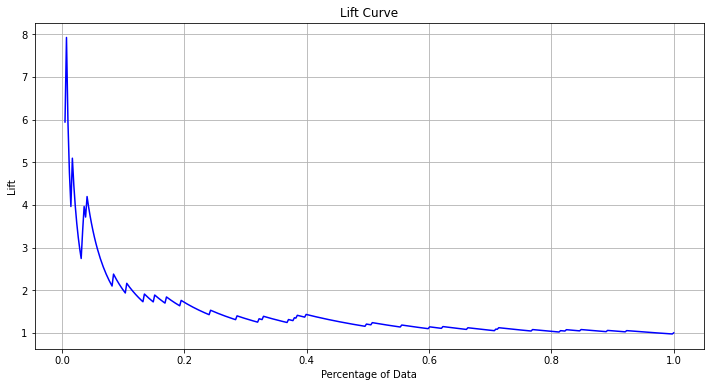

In [22]:
random_cumulative_gain = np.arange(1, len(y_test) + 1) / len(y_test)
lift = cumulative_gain / random_cumulative_gain

# Plot Lift curve
plt.figure(figsize=(12, 6))
# We exclude the first value:
plt.plot(cumulative_percent[1:], lift[1:], color='blue')
plt.xlabel('Percentage of Data')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.grid(True)
plt.show()

The lift curve, as we know, is used in order to see if the model aranges well the predictions, but, we observe that the curve is not descending continuously, there are sometimes where we have some hills. Definetly not a good lift chart.